In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/testminecraft/replay_buffer.hdf5


In [ ]:
# model.py
import torch
import torch.nn as nn

# Annahme: Eingabebilder sind 64x64 Pixel und haben 3 Farbkanäle (RGB)
# Du kannst diese Werte in einer Config-Datei (utils.py) festlegen
IMG_CHANNELS = 3
IMG_HEIGHT = 84
IMG_WIDTH = 84
LATENT_DIM = 256 # Die Dimension des "Gedankens" / Zustandsvektors

class WorldModel(nn.Module):
    def __init__(self):
        super(WorldModel, self).__init__()

        # --- Phase 1: Visueller Encoder ---
        # Verwandelt ein Bild (64x64x3) in einen flachen Vektor
        self.encoder = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 64, kernel_size=4, stride=2, padding=1), # -> 64x64
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1), # -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),        # -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),       # -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),      # -> 4x4
            nn.Flatten() # Macht aus dem 4x4x256 Tensor einen flachen Vektor
        )

        # --- Platzhalter für spätere Phasen ---
        # Repräsentiert das "Gedächtnis" über die Zeit
        # Input: Kodiertes Bild + vorherige Aktion -> Output: Nächster Zustand
        self.recurrent_model = nn.GRU(input_size=LATENT_DIM, hidden_size=LATENT_DIM)

        # --- Phase 1: Visueller Decoder ---
        # Das Gegenstück zum Encoder: Verwandelt den latenten Vektor zurück in ein Bild
        self.decoder = nn.Sequential(
            # Start: Flacher Vektor -> 4x4x256 Tensor
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, IMG_CHANNELS, kernel_size=4, stride=2, padding=1), # -> 64x64
            nn.Sigmoid() # Bringt die Pixelwerte in den Bereich [0, 1]
        )

        # --- Platzhalter für spätere Phasen ---
        # Schätzt die Belohnung basierend auf dem Zustand
        self.reward_predictor = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # Definiert den Datenfluss für ein simples Autoencoder-Training
        # Dies wird später komplexer, wenn das RNN dazu kommt.
        encoded_x = self.encoder(x)
        reconstructed_x = self.decoder(encoded_x)
        return reconstructed_x

Dataset geladen: 31712 Bilder.
Modell auf cpu initialisiert. Starte Training...
Epoch [1/20], Loss: 0.033287
Epoch [2/20], Loss: 0.004614
Epoch [3/20], Loss: 0.003690
Epoch [4/20], Loss: 0.003407
Epoch [5/20], Loss: 0.003243
Epoch [6/20], Loss: 0.003107
Epoch [7/20], Loss: 0.002998
Epoch [8/20], Loss: 0.002915
Epoch [9/20], Loss: 0.002816
Epoch [10/20], Loss: 0.002715
Epoch [11/20], Loss: 0.002604
Epoch [12/20], Loss: 0.002502
Epoch [13/20], Loss: 0.002357
Epoch [14/20], Loss: 0.002261
Epoch [15/20], Loss: 0.002174
Epoch [16/20], Loss: 0.002110
Epoch [17/20], Loss: 0.002043
Epoch [18/20], Loss: 0.001983
Epoch [19/20], Loss: 0.001924
Epoch [20/20], Loss: 0.001866
Training abgeschlossen!
Modell gespeichert.
Erstelle Visualisierung...


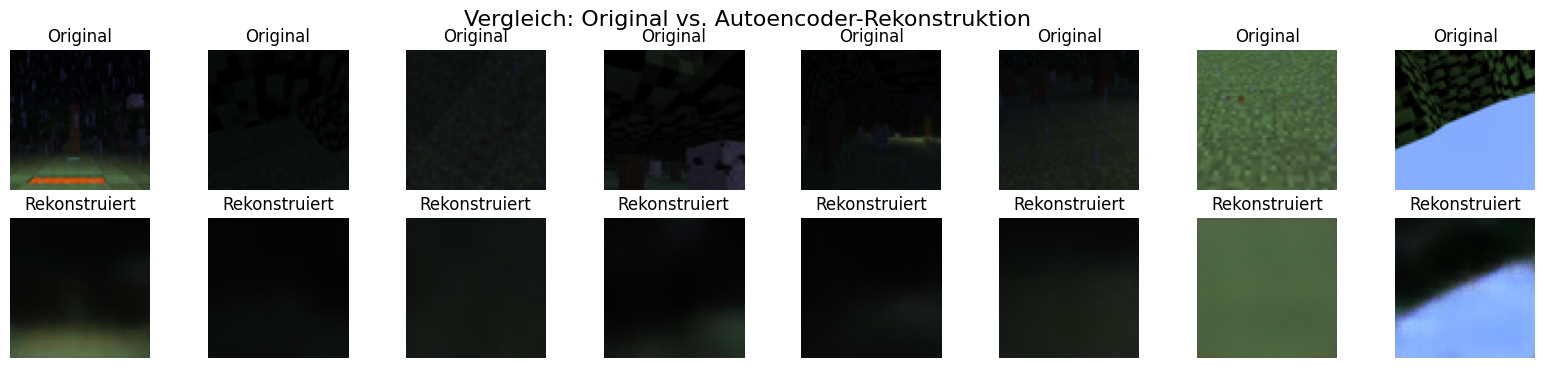

In [1]:
# FÜHRE DIESEN CODE AUS, NACHDEM DU DEN KERNEL NEU GESTARTET HAST
# (UND EVENTUELL PYTORCH NEU INSTALLIERT HAST)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Autoencoder-Modell (für 64x64 Bilder) ---
IMG_CHANNELS = 3
IMG_HEIGHT = 84
IMG_WIDTH = 84

class WorldModel(nn.Module):
    def __init__(self):
        super(WorldModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 2, 2)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, IMG_CHANNELS, kernel_size=4, stride=2, padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

# --- Dataset-Klasse für HDF5 (ohne externe Abhängigkeiten) ---
class HDF5Dataset(Dataset):
    def __init__(self, hdf5_path):
        self.hdf5_path = hdf5_path
        with h5py.File(self.hdf5_path, 'r') as f:
            self.size = f.attrs['size']
    def __len__(self):
        return self.size
    def __getitem__(self, idx):
        with h5py.File(self.hdf5_path, 'r') as f:
            obs = f['obs'][idx]
        obs_cropped = obs[:, 10:74, 10:74]
        return torch.from_numpy(obs_cropped)

# --- Hauptfunktion für Training und Visualisierung ---
def train_and_visualize():
    HDF5_FILE_PATH = "/kaggle/input/testminecraft/replay_buffer.hdf5"
    BATCH_SIZE = 84
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 20
    
    if not Path(HDF5_FILE_PATH).exists():
        print(f"Datei {HDF5_FILE_PATH} nicht gefunden. Erstelle Dummy-Datei.")
        HDF5_FILE_PATH = 'dummy_replay_buffer.hdf5'
        with h5py.File(HDF5_FILE_PATH, 'w') as f:
            f.create_dataset('obs', (128, 3, 84, 84), data=np.random.rand(128, 3, 84, 84).astype(np.float32))
            f.attrs['size'] = 128
            
    dataset = HDF5Dataset(hdf5_path=HDF5_FILE_PATH)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    print(f"Dataset geladen: {len(dataset)} Bilder.")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = WorldModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()
    print(f"Modell auf {device} initialisiert. Starte Training...")

    for epoch in range(NUM_EPOCHS):
        total_loss = 0
        for data_batch in dataloader:
            images = data_batch.to(device)
            reconstructions = model(images)
            loss = criterion(reconstructions, images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {total_loss / len(dataloader):.6f}")

    print("Training abgeschlossen!")
    torch.save(model.state_dict(), "autoencoder_world_model.pth")
    print("Modell gespeichert.")

    print("Erstelle Visualisierung...")
    model.eval()
    with torch.no_grad():
        sample_images = next(iter(dataloader)).to(device)
        reconstructed_images = model(sample_images).cpu().numpy()
    
    n = min(8, len(sample_images))
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        
        plt.imshow(np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0)))
        plt.title("Original")
        ax.axis('off')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
        plt.title("Rekonstruiert")
        ax.axis('off')
    plt.suptitle("Vergleich: Original vs. Autoencoder-Rekonstruktion", fontsize=16)
    plt.savefig("autoencoder_reconstruction.png")
    plt.show()

if __name__ == '__main__':
    train_and_visualize()

In [1]:
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

In [6]:
# 🚀 Kaggle-kompatibles Training mit TensorBoard, Hyperparameter-Search & Checkpointing

# ---------------------------
# Fixes: korrekte AMP API + GPU Auswahl + Infos
# ---------------------------
import os
# Optional: wenn du Probleme mit mehrfachen Registrierungen hast, 
# versuche, nur eine GPU sichtbar zu machen (vermeidet Multi-GPU/Konflikte)
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
# KORRIGIERT: richtige AMP imports
from torch.cuda.amp import GradScaler, autocast

import h5py
import numpy as np
from pathlib import Path
import itertools
import datetime

# Optional: cuDNN Tuning (kann Training beschleunigen, aber evtl. determinismus reduzieren)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# --- Konstanten ---
IMG_CHANNELS = 3
ORIGINAL_HEIGHT = 84
TARGET_HEIGHT = 64
CHECKPOINT_EVERY = 5  # Alle X Epochen speichern

class WorldModel(nn.Module):
    def __init__(self):
        super(WorldModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 2, 2)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, IMG_CHANNELS, 4, 2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

class HDF5Dataset(Dataset):
    def __init__(self, hdf5_path, indices):
        self.hdf5_path = hdf5_path
        self.indices = indices
        self.file = None
        crop_val = (ORIGINAL_HEIGHT - TARGET_HEIGHT) // 2
        self.crop_slice = slice(crop_val, ORIGINAL_HEIGHT - crop_val)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if self.file is None:
            self.file = h5py.File(self.hdf5_path, 'r')
        obs = self.file['obs'][self.indices[idx]]
        obs_cropped = obs[:, self.crop_slice, self.crop_slice]
        return torch.from_numpy(obs_cropped).float()

# --- Training Funktion ---
def train_autoencoder(params, train_loader, val_loader):
    run_name = params['run_name']
    device = params['device']
    
    log_dir = f"runs/{run_name}_{timestamp}"
    writer = SummaryWriter(log_dir=log_dir)

    model = WorldModel().to(device)
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    elif params['optimizer'] == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss()

    # GradScaler für AMP (nur auf CUDA aktiviert)
    use_amp = device.type == 'cuda'
    scaler = GradScaler(enabled=use_amp)

    save_dir = Path("/kaggle/working/models") / run_name
    save_dir.mkdir(parents=True, exist_ok=True)
    best_val_loss = float('inf')

    print(f"🚀 Training gestartet für {run_name}")
    print(f"   Device: {device}")
    print(f"   AMP enabled: {use_amp}")

    for epoch in range(params['num_epochs']):
        # Training
        model.train()
        total_train_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            images = batch.to(device)

            # KORRIGIERT: richtige autocast Verwendung
            if use_amp:
                with autocast():
                    recon = model(images)
                    loss = criterion(recon, images)
                
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Fallback für CPU (ohne AMP)
                recon = model(images)
                loss = criterion(recon, images)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_train_loss += loss.item()
            
            # Optional: Progress info alle 10 batches
            if batch_idx % 10 == 0:
                print(f"   Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.6f}", end='\r')
                
        avg_train_loss = total_train_loss / len(train_loader)
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch.to(device)
                if use_amp:
                    with autocast():
                        recon = model(images)
                        loss = criterion(recon, images)
                else:
                    recon = model(images)
                    loss = criterion(recon, images)
                total_val_loss += loss.item()
                
        avg_val_loss = total_val_loss / len(val_loader)
        writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
        print(f"[{run_name}] Epoch {epoch+1}/{params['num_epochs']} - Train: {avg_train_loss:.6f}, Val: {avg_val_loss:.6f}")

        # Checkpoint speichern
        if (epoch + 1) % CHECKPOINT_EVERY == 0 or (epoch + 1) == params['num_epochs']:
            ckpt_path = save_dir / f"epoch_{epoch+1}.pth"
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict() if use_amp else None,
                'val_loss': avg_val_loss,
                'train_loss': avg_train_loss
            }, ckpt_path)
            print(f"💾 Checkpoint gespeichert: {ckpt_path}")

        # Bestes Modell speichern
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'val_loss': best_val_loss,
                'epoch': epoch+1
            }, save_dir / "best_model.pth")
            print(f"🌟 Neues bestes Modell gespeichert (Val Loss: {best_val_loss:.6f})")

    # Hyperparameter logging
    writer.add_hparams(
        {
            "lr": params['learning_rate'], 
            "bs": params['batch_size'],
            "optimizer": params['optimizer']
        },
        {"hparam/best_validation_loss": best_val_loss}
    )
    writer.close()
    print(f"✅ Training abgeschlossen für {run_name}")

# --- Main ---
if __name__ == '__main__':
    # Check PyTorch und CUDA Version
    print(f"PyTorch Version: {torch.__version__}")
    print(f"CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    HDF5_FILE_PATH = "/kaggle/input/testminecraft/replay_buffer.hdf5"

    # Dataset laden und aufteilen
    print("\n📂 Lade Dataset...")
    with h5py.File(HDF5_FILE_PATH, 'r') as f:
        dataset_size = f.attrs['size']
        print(f"   Dataset Size: {dataset_size} samples")
        indices = np.arange(dataset_size)
    
    np.random.shuffle(indices)
    split_idx = int(len(indices) * 0.9)
    train_idx, val_idx = indices[:split_idx], indices[split_idx:]
    print(f"   Train: {len(train_idx)} samples")
    print(f"   Val: {len(val_idx)} samples")
    
    train_dataset = HDF5Dataset(HDF5_FILE_PATH, train_idx)
    val_dataset = HDF5Dataset(HDF5_FILE_PATH, val_idx)

    # Hyperparameter Grid
    param_grid = {
        'batch_size': [64, 128],
        'learning_rate': [1e-3, 5e-4, 1e-4],
        'optimizer': ['adam', 'adamw'],
        'num_epochs': [40],
    }
    
    keys, values = zip(*param_grid.items())
    total_runs = np.prod([len(v) for v in values])
    print(f"\n🔬 Starte Hyperparameter Search mit {total_runs} Kombinationen\n")

    for run_idx, v in enumerate(itertools.product(*values), 1):
        params = dict(zip(keys, v))
        params['run_name'] = f"BS{params['batch_size']}_LR{params['learning_rate']}_{params['optimizer']}"
        params['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        print(f"\n{'='*60}")
        print(f"Run {run_idx}/{total_runs}: {params['run_name']}")
        print(f"{'='*60}")
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=params['batch_size'], 
            shuffle=True, 
            num_workers=2,  # erhöht von 0 auf 2 für bessere Performance
            pin_memory=True if params['device'].type == 'cuda' else False
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=params['batch_size'], 
            shuffle=False, 
            num_workers=2,
            pin_memory=True if params['device'].type == 'cuda' else False
        )
        
        train_autoencoder(params, train_loader, val_loader)

    # Cleanup
    if train_dataset.file is not None:
        train_dataset.file.close()
    if val_dataset.file is not None:
        val_dataset.file.close()
    
    print("\n🎉 Alle Trainings abgeschlossen!")
    print("📊 TensorBoard logs in: /kaggle/working/runs/")
    print("💾 Modelle gespeichert in: /kaggle/working/models/")

PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
GPU: Tesla P100-PCIE-16GB

📂 Lade Dataset...
   Dataset Size: 31712 samples
   Train: 28540 samples
   Val: 3172 samples

🔬 Starte Hyperparameter Search mit 12 Kombinationen


Run 1/12: BS64_LR0.001_adam
🚀 Training gestartet für BS64_LR0.001_adam
   Device: cuda
   AMP enabled: True


/tmp/ipykernel_36/1285021771.py:93: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)
/tmp/ipykernel_36/1285021771.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


/tmp/ipykernel_36/1285021771.py:145: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[BS64_LR0.001_adam] Epoch 1/40 - Train: 0.009896, Val: 0.003091
🌟 Neues bestes Modell gespeichert (Val Loss: 0.003091)
[BS64_LR0.001_adam] Epoch 2/40 - Train: 0.002712, Val: 0.002401
🌟 Neues bestes Modell gespeichert (Val Loss: 0.002401)
[BS64_LR0.001_adam] Epoch 3/40 - Train: 0.002217, Val: 0.002277
🌟 Neues bestes Modell gespeichert (Val Loss: 0.002277)
[BS64_LR0.001_adam] Epoch 4/40 - Train: 0.001909, Val: 0.001900
🌟 Neues bestes Modell gespeichert (Val Loss: 0.001900)
[BS64_LR0.001_adam] Epoch 5/40 - Train: 0.001676, Val: 0.001633
💾 Checkpoint gespeichert: /kaggle/working/models/BS64_LR0.001_adam/epoch_5.pth
🌟 Neues bestes Modell gespeichert (Val Loss: 0.001633)
[BS64_LR0.001_adam] Epoch 6/40 - Train: 0.001563, Val: 0.001587
🌟 Neues bestes Modell gespeichert (Val Loss: 0.001587)
[BS64_LR0.001_adam] Epoch 7/40 - Train: 0.001468, Val: 0.001519
🌟 Neues bestes Modell gespeichert (Val Loss: 0.001519)
[BS64_LR0.001_adam] Epoch 8/40 - Train: 0.001383, Val: 0.001490
🌟 Neues bestes Modell ge

🎨 VISUALISIERUNG DER TRAINIERTEN MODELLE

📊 1. BESTE MODELLE VERGLEICH:
🖥️ Device: cuda
📁 Gefundene Modelle: 13

📊 Modell 1/3: BS64_LR0.001_adamw
   Validation Loss: 0.000957
   💾 Gespeichert: /kaggle/working/visualization_1_BS64_LR0.001_adamw.png


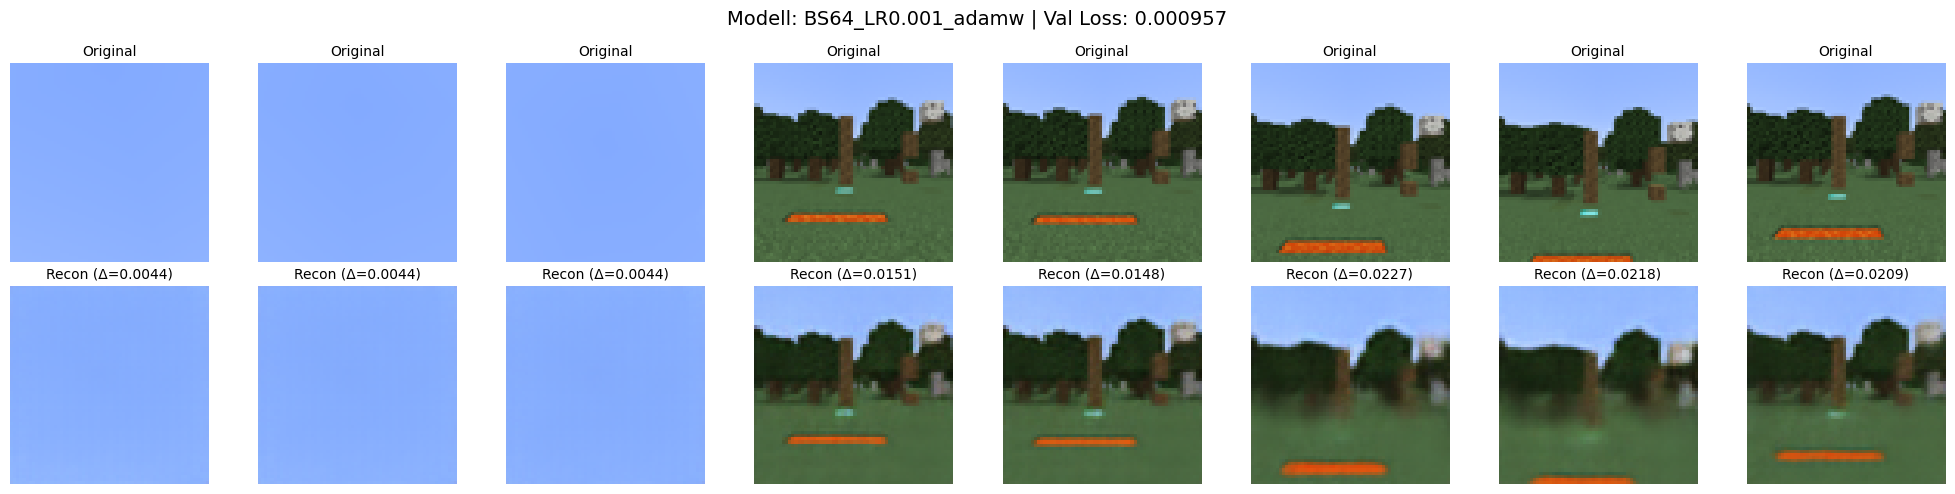


📊 Modell 2/3: BS64_LR0.001_adam
   Validation Loss: 0.000965
   💾 Gespeichert: /kaggle/working/visualization_2_BS64_LR0.001_adam.png


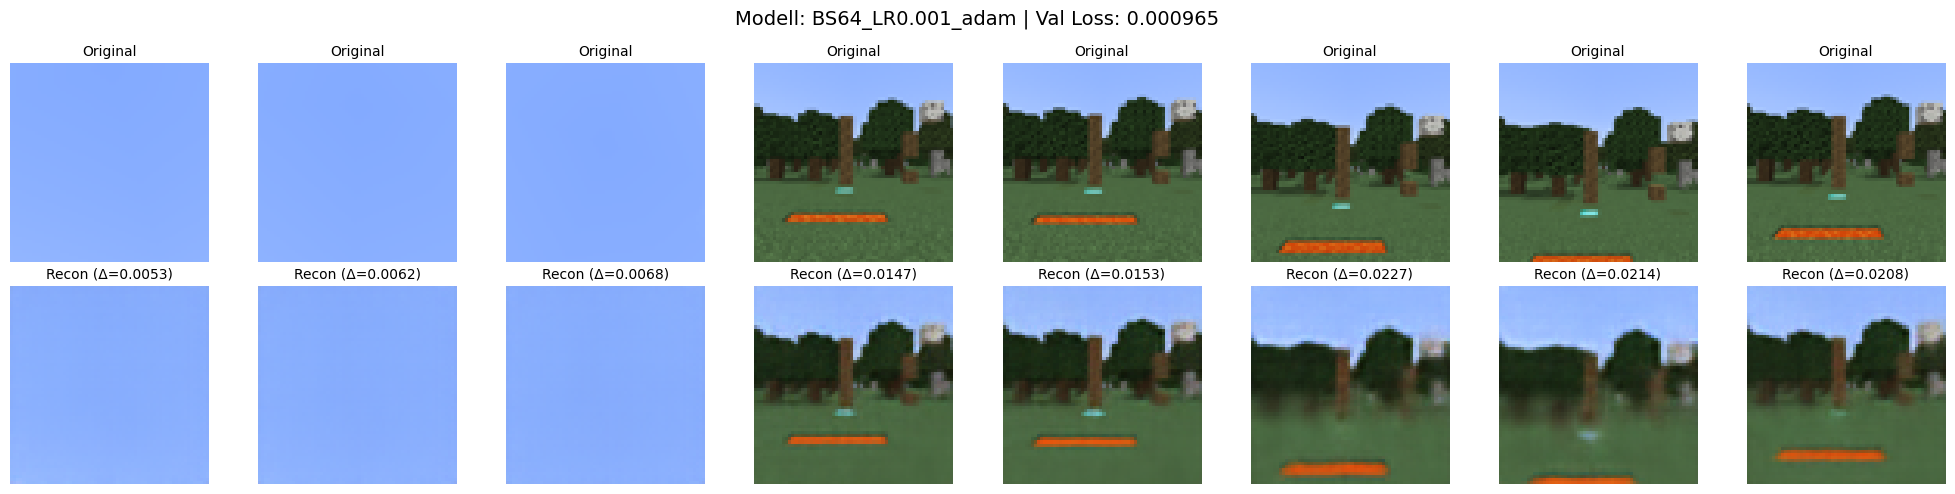


📊 Modell 3/3: BS64_LR0.0005_adam
   Validation Loss: 0.000976
   💾 Gespeichert: /kaggle/working/visualization_3_BS64_LR0.0005_adam.png


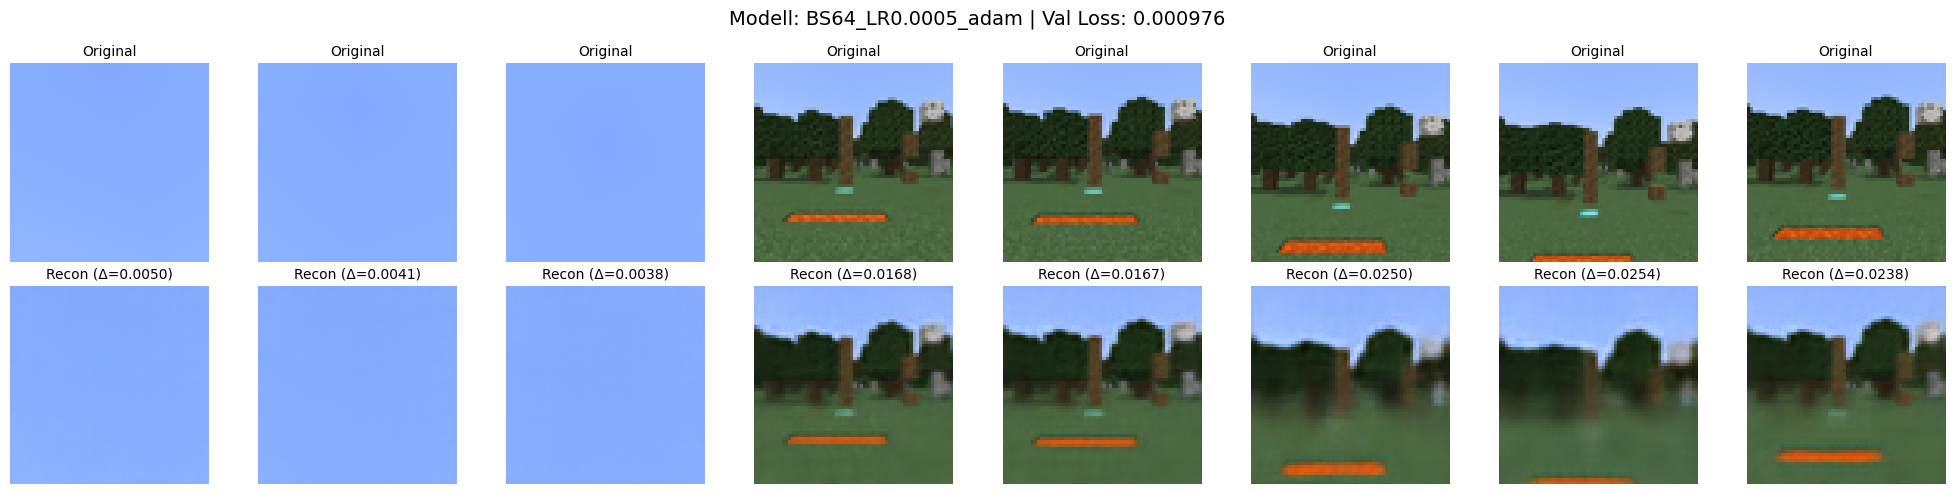


📈 2. TRAINING PROGRESSION:
📁 Gefundene Checkpoints: 8
💾 Gespeichert: /kaggle/working/training_progression_BS64_LR0.001_adam.png


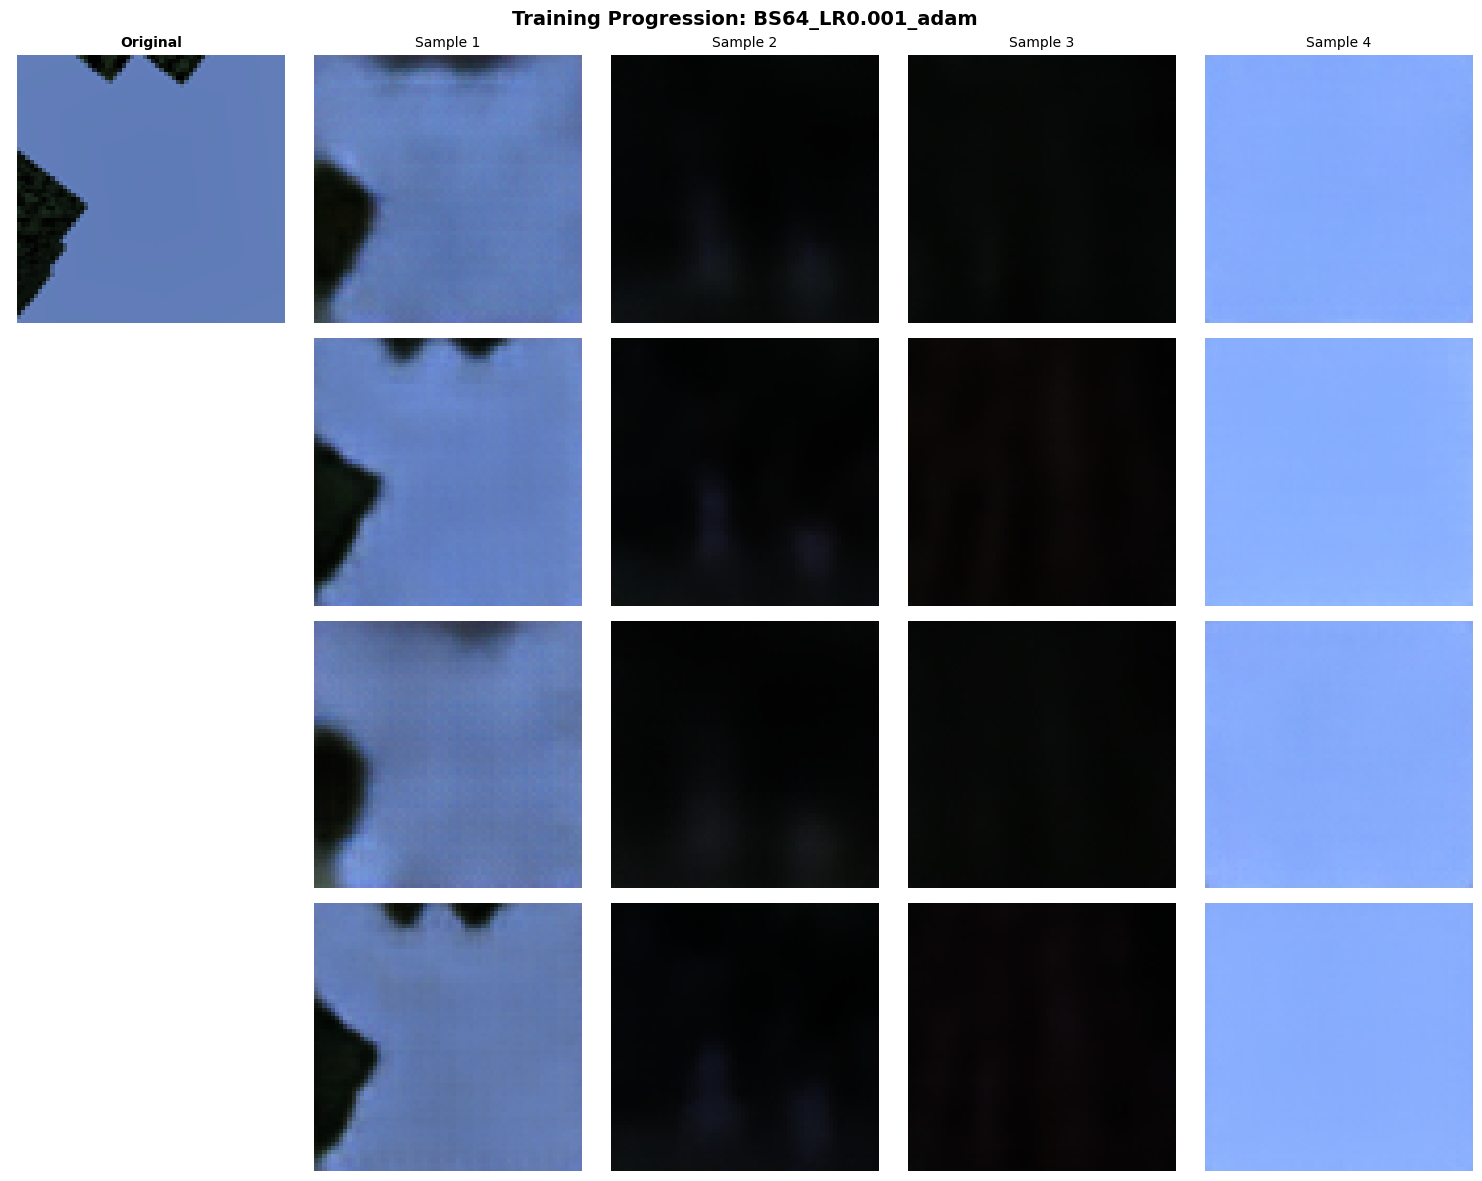


📉 3. LOSS KURVEN:
💾 Loss Vergleich gespeichert: /kaggle/working/loss_comparison.png


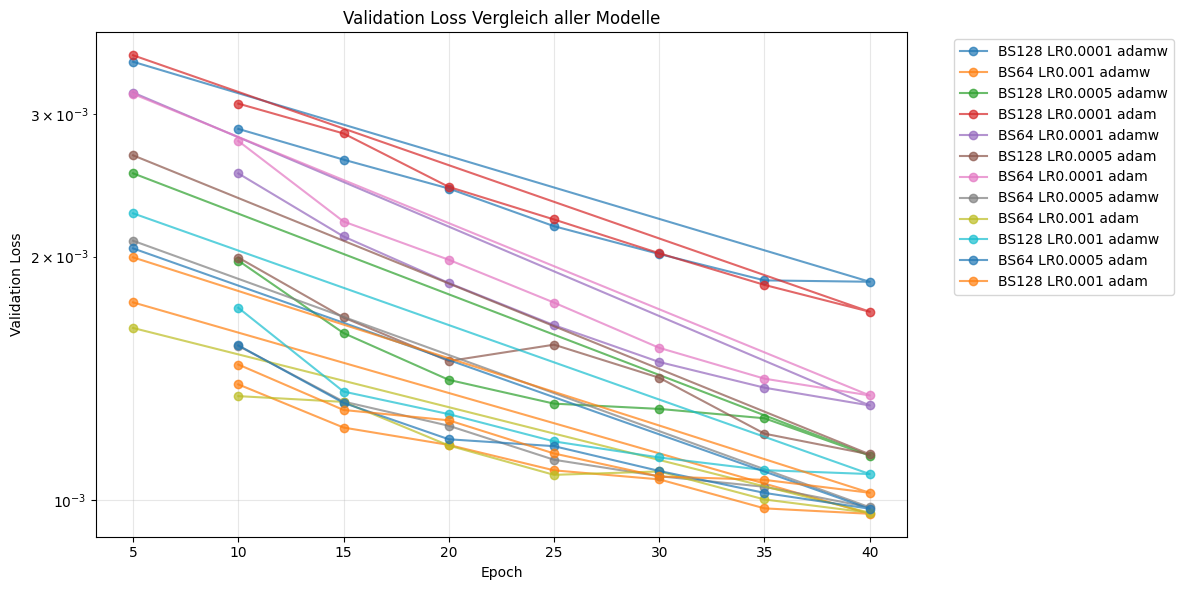


✅ Alle Visualisierungen abgeschlossen!
   Check /kaggle/working/ für die gespeicherten Bilder


In [15]:
# 🎨 STANDALONE VISUALISIERUNG - Komplett unabhängig vom Training Code
# Lädt und visualisiert die trainierten Modelle

import matplotlib.pyplot as plt

# --- HAUPTFUNKTION: Visualisiere beste Modelle ---
def visualize_all_best_models():
    """Lädt und visualisiert alle besten Modelle aus dem Training"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🖥️ Device: {device}")
    
    # Dataset vorbereiten
    HDF5_FILE_PATH = "/kaggle/input/testminecraft/replay_buffer.hdf5"
    
    # Lade ein paar Validation Samples
    with h5py.File(HDF5_FILE_PATH, 'r') as f:
        total_size = f.attrs['size']
    
    # Nimm die letzten 100 Samples als Test
    test_indices = np.arange(total_size - 100, total_size)
    test_dataset = HDF5Dataset(HDF5_FILE_PATH, test_indices)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    
    # Finde alle best_model.pth Dateien
    model_dir = Path("/kaggle/working/models")
    best_models = list(model_dir.glob("*/best_model.pth"))
    
    if not best_models:
        print("❌ Keine trainierten Modelle gefunden!")
        return
    
    print(f"📁 Gefundene Modelle: {len(best_models)}")
    
    # Sortiere nach Loss (beste zuerst)
    model_losses = []
    for model_path in best_models:
        try:
            checkpoint = torch.load(model_path, map_location=device)
            val_loss = checkpoint.get('val_loss', float('inf'))
            model_losses.append((model_path, val_loss))
        except:
            continue
    
    model_losses.sort(key=lambda x: x[1])
    
    # Visualisiere die Top 3 Modelle
    num_to_show = min(3, len(model_losses))
    
    for idx, (model_path, val_loss) in enumerate(model_losses[:num_to_show]):
        print(f"\n{'='*60}")
        print(f"📊 Modell {idx+1}/{num_to_show}: {model_path.parent.name}")
        print(f"   Validation Loss: {val_loss:.6f}")
        
        # Lade Modell
        model = WorldModel().to(device)
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        # Hole Sample Batch
        with torch.no_grad():
            sample_batch = next(iter(test_loader)).to(device)
            reconstructions = model(sample_batch)
        
        # Visualisierung
        fig, axes = plt.subplots(2, 8, figsize=(20, 5))
        fig.suptitle(f'Modell: {model_path.parent.name} | Val Loss: {val_loss:.6f}', fontsize=14)
        
        for i in range(min(8, len(sample_batch))):
            # Original
            orig_img = sample_batch[i].cpu().permute(1, 2, 0).numpy()
            axes[0, i].imshow(orig_img)
            axes[0, i].set_title('Original', fontsize=10)
            axes[0, i].axis('off')
            
            # Rekonstruktion
            recon_img = reconstructions[i].cpu().permute(1, 2, 0).numpy()
            axes[1, i].imshow(recon_img)
            
            # Berechne pixel-wise difference
            diff = np.mean(np.abs(orig_img - recon_img))
            axes[1, i].set_title(f'Recon (Δ={diff:.4f})', fontsize=10)
            axes[1, i].axis('off')
        
        plt.tight_layout()
        save_path = f'/kaggle/working/visualization_{idx+1}_{model_path.parent.name}.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"   💾 Gespeichert: {save_path}")
        plt.show()
    
    # Cleanup
    if hasattr(test_dataset, 'file') and test_dataset.file:
        test_dataset.file.close()

# --- Vergleiche verschiedene Checkpoints eines Modells ---
def visualize_training_progression(model_name="BS64_LR0.001_adam"):
    """Zeigt wie sich die Rekonstruktionen über die Epochen verbessern"""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_dir = Path(f"/kaggle/working/models/{model_name}")
    
    if not model_dir.exists():
        print(f"❌ Modell {model_name} nicht gefunden!")
        print(f"   Verfügbare Modelle:")
        for m in Path("/kaggle/working/models").glob("*"):
            print(f"   - {m.name}")
        return
    
    # Finde alle Checkpoints
    checkpoints = sorted(model_dir.glob("epoch_*.pth"))
    
    if not checkpoints:
        print(f"❌ Keine Checkpoints für {model_name} gefunden!")
        return
    
    print(f"📁 Gefundene Checkpoints: {len(checkpoints)}")
    
    # Dataset vorbereiten
    HDF5_FILE_PATH = "/kaggle/input/testminecraft/replay_buffer.hdf5"
    with h5py.File(HDF5_FILE_PATH, 'r') as f:
        total_size = f.attrs['size']
    
    # Nimm immer die gleichen Samples für konsistenten Vergleich
    np.random.seed(42)
    test_indices = np.random.choice(total_size, 4, replace=False)
    test_dataset = HDF5Dataset(HDF5_FILE_PATH, test_indices)
    test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
    
    # Wähle Checkpoints aus (Anfang, Mitte, Ende)
    checkpoints_to_show = [
        checkpoints[0],  # Erste
        checkpoints[len(checkpoints)//2],  # Mitte
        checkpoints[-1]  # Letzte
    ]
    
    # Füge best_model hinzu wenn vorhanden
    best_model_path = model_dir / "best_model.pth"
    if best_model_path.exists():
        checkpoints_to_show.append(best_model_path)
    
    # Visualisierung
    fig, axes = plt.subplots(len(checkpoints_to_show), 5, figsize=(15, 3*len(checkpoints_to_show)))
    if len(checkpoints_to_show) == 1:
        axes = axes.reshape(1, -1)
    
    sample_batch = next(iter(test_loader)).to(device)
    
    for row_idx, ckpt_path in enumerate(checkpoints_to_show):
        # Lade Checkpoint
        checkpoint = torch.load(ckpt_path, map_location=device)
        epoch = checkpoint.get('epoch', 'best')
        val_loss = checkpoint.get('val_loss', 0)
        
        # Lade Modell
        model = WorldModel().to(device)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        with torch.no_grad():
            reconstructions = model(sample_batch)
        
        # Zeige Original in erster Spalte (nur erste Reihe)
        if row_idx == 0:
            orig_img = sample_batch[0].cpu().permute(1, 2, 0).numpy()
            axes[row_idx, 0].imshow(orig_img)
            axes[row_idx, 0].set_title('Original', fontsize=10, fontweight='bold')
            axes[row_idx, 0].axis('off')
        else:
            axes[row_idx, 0].axis('off')
        
        # Label für die Reihe
        axes[row_idx, 0].set_ylabel(f'Epoch {epoch}\nLoss: {val_loss:.6f}', 
                                    fontsize=10, rotation=0, ha='right', va='center')
        
        # Zeige 4 Rekonstruktionen
        for i in range(4):
            recon_img = reconstructions[i].cpu().permute(1, 2, 0).numpy()
            axes[row_idx, i+1].imshow(recon_img)
            axes[row_idx, i+1].axis('off')
            
            if row_idx == 0:
                axes[row_idx, i+1].set_title(f'Sample {i+1}', fontsize=10)
    
    fig.suptitle(f'Training Progression: {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    save_path = f'/kaggle/working/training_progression_{model_name}.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"💾 Gespeichert: {save_path}")
    plt.show()
    
    # Cleanup
    if hasattr(test_dataset, 'file') and test_dataset.file:
        test_dataset.file.close()

# --- Loss Kurven plotten ---
def plot_loss_comparison():
    """Vergleicht die Loss-Kurven aller Modelle"""
    
    import re
    
    model_dir = Path("/kaggle/working/models")
    
    plt.figure(figsize=(12, 6))
    
    for model_path in model_dir.glob("*/"):
        checkpoints = sorted(model_path.glob("epoch_*.pth"))
        if not checkpoints:
            continue
        
        epochs = []
        train_losses = []
        val_losses = []
        
        for ckpt in checkpoints:
            try:
                checkpoint = torch.load(ckpt, map_location='cpu')
                epochs.append(checkpoint['epoch'])
                train_losses.append(checkpoint.get('train_loss', np.nan))
                val_losses.append(checkpoint['val_loss'])
            except:
                continue
        
        if epochs:
            label = model_path.name.replace('_', ' ')
            plt.plot(epochs, val_losses, marker='o', label=label, alpha=0.7)
    
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Vergleich aller Modelle')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    save_path = '/kaggle/working/loss_comparison.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"💾 Loss Vergleich gespeichert: {save_path}")
    plt.show()

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    print("🎨 VISUALISIERUNG DER TRAINIERTEN MODELLE")
    print("="*60)
    
    # 1. Zeige die besten Modelle
    print("\n📊 1. BESTE MODELLE VERGLEICH:")
    visualize_all_best_models()
    
    # 2. Zeige Training Progression für das beste Modell
    print("\n📈 2. TRAINING PROGRESSION:")
    visualize_training_progression("BS64_LR0.001_adam")  # Ändere zu deinem besten Modell
    
    # 3. Loss Kurven Vergleich
    print("\n📉 3. LOSS KURVEN:")
    plot_loss_comparison()
    
    print("\n✅ Alle Visualisierungen abgeschlossen!")
    print("   Check /kaggle/working/ für die gespeicherten Bilder")

In [24]:
#!/usr/bin/env python3
"""
🚀 KAGGLE DOWNLOAD PREP - Erstellt ein optimiertes Download-Paket
   Reduziert ~500MB auf ~50MB mit nur den wichtigsten Files!
"""

import torch
import shutil
import zipfile
import json
import tarfile
from pathlib import Path
import numpy as np

# ============ KONFIGURATION ============
# Ändere diese Variablen nach Bedarf!
TOP_N_MODELS = 3  # Wieviele der besten Modelle sollen gespeichert werden? (1-10 empfohlen)
INCLUDE_TENSORBOARD = True  # TensorBoard Logs mit einpacken?
INCLUDE_VISUALIZATIONS = True  # PNG Visualisierungen mit einpacken?
CLEANUP_OLD_CHECKPOINTS = False  # Alte Checkpoints automatisch löschen?
# ========================================

def prepare_download_package(top_n_models=None):
    """
    Erstellt ein optimiertes Download-Paket mit nur den wichtigsten Daten
    
    Args:
        top_n_models: Anzahl der besten Modelle die gespeichert werden sollen 
                     (None = nutzt globale Variable TOP_N_MODELS)
    """
    
    # Nutze Parameter oder globale Variable
    if top_n_models is None:
        top_n_models = TOP_N_MODELS
    
    print("="*60)
    print("📦 DOWNLOAD PACKAGE VORBEREITUNG")
    print("="*60)
    print(f"\n⚙️ Einstellungen:")
    print(f"   - Top {top_n_models} Modelle speichern")
    print(f"   - TensorBoard Logs: {'✅ Ja' if INCLUDE_TENSORBOARD else '❌ Nein'}")
    print(f"   - Visualisierungen: {'✅ Ja' if INCLUDE_VISUALIZATIONS else '❌ Nein'}")
    
    # Basis-Verzeichnisse
    model_dir = Path("/kaggle/working/models")
    output_dir = Path("/kaggle/working")
    
    # Download Ordner erstellen
    download_dir = output_dir / "DOWNLOAD_THIS"
    download_dir.mkdir(exist_ok=True)
    
    # ========== 1. BESTE MODELLE FINDEN ==========
    print("\n1️⃣ Suche beste Modelle...")
    
    model_stats = []
    for model_path in model_dir.glob("*/best_model.pth"):
        try:
            checkpoint = torch.load(model_path, map_location='cpu')
            val_loss = checkpoint.get('val_loss', float('inf'))
            epoch = checkpoint.get('epoch', 0)
            
            model_stats.append({
                'name': model_path.parent.name,
                'path': model_path,
                'val_loss': float(val_loss),  # Sicherstellen dass es float ist
                'epoch': int(epoch),
                'size_mb': model_path.stat().st_size / 1024 / 1024
            })
        except Exception as e:
            print(f"   ⚠️ Fehler bei {model_path}: {e}")
    
    # Sortiere nach Loss
    model_stats.sort(key=lambda x: x['val_loss'])
    
    print(f"   ✅ {len(model_stats)} Modelle gefunden")
    
    if not model_stats:
        print("   ❌ Keine trainierten Modelle gefunden!")
        return None
    
    # Begrenzen auf verfügbare Modelle
    actual_top_n = min(top_n_models, len(model_stats))
    
    # ========== 2. TOP MODELLE KOPIEREN ==========
    print(f"\n2️⃣ Kopiere Top {actual_top_n} Modelle...")
    
    models_dir = download_dir / "models"
    models_dir.mkdir(exist_ok=True)
    
    total_model_size = 0
    for i, model in enumerate(model_stats[:actual_top_n]):
        # Besserer Filename mit Rank und Loss
        new_name = f"rank{i+1}_loss{model['val_loss']:.6f}_{model['name']}.pth"
        dest_path = models_dir / new_name
        
        shutil.copy(model['path'], dest_path)
        total_model_size += model['size_mb']
        print(f"   ✅ Rank {i+1}: {model['name']}")
        print(f"      Loss: {model['val_loss']:.6f} | Epoch: {model['epoch']} | Size: {model['size_mb']:.2f} MB")
    
    print(f"   📊 Gesamt: {total_model_size:.2f} MB für {actual_top_n} Modelle")
    
    # ========== 3. MODEL SUMMARY ERSTELLEN ==========
    print("\n3️⃣ Erstelle Model Summary...")
    
    # Extrahiere Hyperparameter aus Namen
    def parse_model_name(name):
        parts = name.split('_')
        hp = {}
        try:
            hp['batch_size'] = int(parts[0].replace('BS', '')) if 'BS' in parts[0] else None
            hp['learning_rate'] = float(parts[1].replace('LR', '')) if len(parts) > 1 and 'LR' in parts[1] else None
            hp['optimizer'] = parts[2] if len(parts) > 2 else 'unknown'
        except:
            hp = {'batch_size': None, 'learning_rate': None, 'optimizer': 'unknown'}
        return hp
    
    summary = {
        'training_info': {
            'total_models_trained': len(model_stats),
            'models_saved': actual_top_n,
            'best_loss_achieved': model_stats[0]['val_loss'],
            'best_model': model_stats[0]['name'],
            'best_model_epoch': model_stats[0]['epoch']
        },
        'model_rankings': []
    }
    
    for i, model in enumerate(model_stats):
        hp = parse_model_name(model['name'])
        summary['model_rankings'].append({
            'rank': i + 1,
            'name': model['name'],
            'val_loss': model['val_loss'],
            'epoch': model['epoch'],
            'saved': i < actual_top_n,  # Markiere welche gespeichert wurden
            'hyperparameters': hp
        })
    
    with open(download_dir / 'training_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    print(f"   ✅ Summary für alle {len(model_stats)} Modelle gespeichert")
    
    # ========== 4. VISUALISIERUNGEN KOPIEREN ==========
    if INCLUDE_VISUALIZATIONS:
        print("\n4️⃣ Sammle Visualisierungen...")
        
        viz_dir = download_dir / "visualizations"
        viz_dir.mkdir(exist_ok=True)
        
        viz_count = 0
        viz_size = 0
        for img_path in output_dir.glob("*.png"):
            shutil.copy(img_path, viz_dir / img_path.name)
            viz_count += 1
            viz_size += img_path.stat().st_size / 1024 / 1024
        
        if viz_count > 0:
            print(f"   ✅ {viz_count} Visualisierungen kopiert ({viz_size:.2f} MB)")
        else:
            print(f"   ⚠️ Keine Visualisierungen gefunden")
    
    # ========== 5. TENSORBOARD LOGS (OPTIONAL) ==========
    if INCLUDE_TENSORBOARD:
        print("\n5️⃣ Komprimiere TensorBoard Logs...")
        
        runs_dir = output_dir / "runs"
        if runs_dir.exists():
            tb_archive = download_dir / "tensorboard_logs.tar.gz"
            with tarfile.open(tb_archive, 'w:gz') as tar:
                tar.add(runs_dir, arcname='runs')
            
            tb_size = tb_archive.stat().st_size / 1024 / 1024
            print(f"   ✅ TensorBoard Logs: {tb_size:.2f} MB")
        else:
            print(f"   ⚠️ Keine TensorBoard Logs gefunden")
    
    # ========== 6. README ERSTELLEN ==========
    print("\n6️⃣ Erstelle README...")
    
    # Formatiere Best Loss für README
    best_loss_str = f"{model_stats[0]['val_loss']:.6f}" if model_stats else "N/A"
    best_model_str = model_stats[0]['name'] if model_stats else "N/A"
    
    readme_content = f"""# 🚀 KAGGLE TRAINING RESULTS

## 📊 Training Summary
- **Total Models Trained:** {len(model_stats)}
- **Models Saved:** Top {actual_top_n}
- **Best Model:** {best_model_str}
- **Best Validation Loss:** {best_loss_str}

## 📁 Package Contents

### /models
Die Top {actual_top_n} Modelle nach Validation Loss sortiert.
Gesamt: {total_model_size:.2f} MB

### /visualizations
{"Alle generierten Visualisierungen und Plots." if INCLUDE_VISUALIZATIONS else "Nicht inkludiert (deaktiviert)"}

### /tensorboard_logs.tar.gz
{"Komprimierte TensorBoard Logs." if INCLUDE_TENSORBOARD else "Nicht inkludiert (deaktiviert)"}

Entpacken mit:
```bash
tar -xzf tensorboard_logs.tar.gz
tensorboard --logdir runs/
```

### training_summary.json
Detaillierte Statistiken ALLER {len(model_stats)} trainierten Modelle.

## 🔧 Modell Laden

```python
import torch
import torch.nn as nn

# Model Definition (aus dem Training Code)
class WorldModel(nn.Module):
    def __init__(self):
        super(WorldModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 2, 2)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

# Modell laden
model = WorldModel()
checkpoint = torch.load('models/rank1_{best_model_str}.pth', map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Validation Loss abrufen
print(f"Loaded model with validation loss: {{checkpoint['val_loss']:.6f}}")
```

## 📈 Top {min(10, len(model_stats))} Modelle

| Rank | Model | Val Loss | Epoch | Saved |
|------|-------|----------|-------|-------|
"""
    
    for i, model in enumerate(model_stats[:min(10, len(model_stats))]):
        saved_marker = "✅" if i < actual_top_n else "❌"
        readme_content += f"| {i+1} | {model['name']} | {model['val_loss']:.6f} | {model['epoch']} | {saved_marker} |\n"
    
    if len(model_stats) > 10:
        readme_content += f"\n*Zeigt nur Top 10 von {len(model_stats)} Modellen. Siehe training_summary.json für alle.*\n"
    
    with open(download_dir / 'README.md', 'w') as f:
        f.write(readme_content)
    print(f"   ✅ README erstellt")
    
    # ========== 7. FINALES ZIP ERSTELLEN ==========
    print("\n7️⃣ Erstelle finales ZIP...")
    
    zip_path = output_dir / f"kaggle_top{actual_top_n}_models.zip"
    
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Füge alles aus DOWNLOAD_THIS hinzu
        for file_path in download_dir.rglob('*'):
            if file_path.is_file():
                arcname = str(file_path.relative_to(download_dir))
                zipf.write(file_path, arcname)
    
    final_size = zip_path.stat().st_size / 1024 / 1024
    
    # ========== ZUSAMMENFASSUNG ==========
    print("\n" + "="*60)
    print("✅ DOWNLOAD PACKAGE BEREIT!")
    print("="*60)
    print(f"\n📦 Hauptpaket: {zip_path}")
    print(f"   Größe: {final_size:.2f} MB")
    print(f"\n📁 Oder download den Ordner: /kaggle/working/DOWNLOAD_THIS/")
    
    # Größen-Übersicht
    total_size = sum(f.stat().st_size for f in download_dir.rglob('*') if f.is_file())
    print(f"\n📊 Paket-Inhalt:")
    print(f"   - Top {actual_top_n} Modelle: {total_model_size:.2f} MB")
    if INCLUDE_VISUALIZATIONS and viz_count > 0:
        print(f"   - Visualisierungen: {viz_count} Dateien ({viz_size:.2f} MB)")
    if INCLUDE_TENSORBOARD and 'tb_size' in locals():
        print(f"   - TensorBoard Logs: {tb_size:.2f} MB")
    print(f"   - Gesamt (unkomprimiert): {total_size/1024/1024:.2f} MB")
    print(f"   - Gesamt (ZIP): {final_size:.2f} MB")
    
    # Kompressionsrate
    compression_rate = (1 - final_size / (total_size/1024/1024)) * 100
    print(f"   - Kompressionsrate: {compression_rate:.1f}%")
    
    print("\n💡 DOWNLOAD OPTIONEN:")
    print(f"   1. Klicke auf 'Output' → Download '{zip_path.name}'")
    print("   2. Oder: Output → Download All (größer, enthält alles)")
    print(f"   3. Via API: kaggle kernels output USERNAME/NOTEBOOK -f {zip_path.name}")
    
    return zip_path

# ========== CLEANUP FUNKTION ==========
def cleanup_unnecessary_files():
    """Löscht unnötige Checkpoints um Platz zu sparen"""
    
    print("\n🧹 Cleanup unnötiger Files...")
    
    if not CLEANUP_OLD_CHECKPOINTS:
        print("   ⏭️ Übersprungen (in Konfiguration deaktiviert)")
        return
    
    model_dir = Path("/kaggle/working/models")
    deleted_count = 0
    freed_space = 0
    
    for checkpoint in model_dir.glob("*/epoch_*.pth"):
        # Behalte nur die letzten Checkpoints (35, 40)
        try:
            epoch_num = int(checkpoint.stem.split('_')[1])
            if epoch_num not in [35, 40]:
                size = checkpoint.stat().st_size
                checkpoint.unlink()
                deleted_count += 1
                freed_space += size
        except:
            continue
    
    if deleted_count > 0:
        print(f"   ✅ {deleted_count} alte Checkpoints gelöscht")
        print(f"   💾 {freed_space/1024/1024:.2f} MB freigemacht")
    else:
        print(f"   ℹ️ Keine alten Checkpoints zum Löschen gefunden")

# ========== INTERACTIVE MODE ==========
def interactive_setup():
    """Interaktiver Modus für Benutzer-Konfiguration"""
    
    global TOP_N_MODELS, INCLUDE_TENSORBOARD, INCLUDE_VISUALIZATIONS, CLEANUP_OLD_CHECKPOINTS
    print("\n🎮 INTERAKTIVER MODUS")
    print("="*60)
    
    # Anzahl Modelle
    while True:
        try:
            n = input(f"Wieviele der besten Modelle speichern? [1-10, default={TOP_N_MODELS}]: ").strip()
            if not n:
                n = TOP_N_MODELS
                break
            n = int(n)
            if 1 <= n <= 10:
                break
            print("   ⚠️ Bitte eine Zahl zwischen 1 und 10 eingeben")
        except ValueError:
            print("   ⚠️ Ungültige Eingabe")
    
    # TensorBoard
    tb = input(f"TensorBoard Logs inkludieren? [y/N]: ").strip().lower() == 'y'
    
    # Visualisierungen
    viz = input(f"Visualisierungen (PNG) inkludieren? [Y/n]: ").strip().lower() != 'n'
    
    # Cleanup
    cleanup = input(f"Alte Checkpoints löschen? [y/N]: ").strip().lower() == 'y'
    
    # Setze globale Variablen
    TOP_N_MODELS = n
    INCLUDE_TENSORBOARD = tb
    INCLUDE_VISUALIZATIONS = viz
    CLEANUP_OLD_CHECKPOINTS = cleanup
    
    print("\n✅ Konfiguration:")
    print(f"   - Top {TOP_N_MODELS} Modelle")
    print(f"   - TensorBoard: {'Ja' if INCLUDE_TENSORBOARD else 'Nein'}")
    print(f"   - Visualisierungen: {'Ja' if INCLUDE_VISUALIZATIONS else 'Nein'}")
    print(f"   - Cleanup: {'Ja' if CLEANUP_OLD_CHECKPOINTS else 'Nein'}")
    
    confirm = input("\nFortfahren? [Y/n]: ").strip().lower()
    return confirm != 'n'

# ========== MAIN ==========
if __name__ == "__main__":
    print("🚀 KAGGLE MODEL DOWNLOAD PREP")
    print("="*60)
    
    # Optional: Interaktiver Modus
    use_interactive = input("Interaktiven Modus nutzen? [y/N]: ").strip().lower() == 'y'
    
    if use_interactive:
        if not interactive_setup():
            print("❌ Abgebrochen")
            exit(0)
    else:
        print(f"\n📌 Nutze Standard-Konfiguration:")
        print(f"   - Top {TOP_N_MODELS} Modelle")
        print(f"   - TensorBoard: {'Ja' if INCLUDE_TENSORBOARD else 'Nein'}")
        print(f"   - Visualisierungen: {'Ja' if INCLUDE_VISUALIZATIONS else 'Nein'}")
    
    # Erstelle optimiertes Download-Paket
    zip_file = prepare_download_package()
    
    # Optional: Cleanup
    if CLEANUP_OLD_CHECKPOINTS:
        cleanup_unnecessary_files()
    
    if zip_file:
        print("\n🎉 FERTIG! Jetzt einfach downloaden!")
        print("   Viel Spaß mit deinen trainierten Modellen! 🚀")
    else:
        print("\n❌ Keine Modelle zum Downloaden gefunden!")
        print("   Stelle sicher dass das Training abgeschlossen ist.")

🚀 KAGGLE MODEL DOWNLOAD PREP


Interaktiven Modus nutzen? [y/N]:  y



🎮 INTERAKTIVER MODUS


Wieviele der besten Modelle speichern? [1-10, default=3]:  10
TensorBoard Logs inkludieren? [y/N]:  y
Visualisierungen (PNG) inkludieren? [Y/n]:  y
Alte Checkpoints löschen? [y/N]:  n



✅ Konfiguration:
   - Top 10 Modelle
   - TensorBoard: Ja
   - Visualisierungen: Ja
   - Cleanup: Nein



Fortfahren? [Y/n]:  y


📦 DOWNLOAD PACKAGE VORBEREITUNG

⚙️ Einstellungen:
   - Top 10 Modelle speichern
   - TensorBoard Logs: ✅ Ja
   - Visualisierungen: ✅ Ja

1️⃣ Suche beste Modelle...
   ✅ 13 Modelle gefunden

2️⃣ Kopiere Top 10 Modelle...
   ✅ Rank 1: BS64_LR0.001_adamw
      Loss: 0.000957 | Epoch: 38 | Size: 5.53 MB
   ✅ Rank 2: BS64_LR0.001_adam
      Loss: 0.000965 | Epoch: 40 | Size: 5.53 MB
   ✅ Rank 3: BS64_LR0.0005_adam
      Loss: 0.000976 | Epoch: 40 | Size: 5.53 MB
   ✅ Rank 4: BS64_LR0.0005_adamw
      Loss: 0.000980 | Epoch: 40 | Size: 5.53 MB
   ✅ Rank 5: BS128_LR0.001_adam
      Loss: 0.001003 | Epoch: 38 | Size: 5.53 MB
   ✅ Rank 6: BS128_LR0.001_adamw
      Loss: 0.001015 | Epoch: 39 | Size: 5.53 MB
   ✅ Rank 7: BS128_LR0.0005_adamw
      Loss: 0.001136 | Epoch: 40 | Size: 5.53 MB
   ✅ Rank 8: BS128_LR0.0005_adam
      Loss: 0.001140 | Epoch: 40 | Size: 5.53 MB
   ✅ Rank 9: BS64_LR0.0001_adamw
      Loss: 0.001310 | Epoch: 40 | Size: 5.53 MB
   ✅ Rank 10: BS64_LR0.0001_adam
      Loss: 

In [32]:
!zip -r download_this.zip DOWNLOAD_THIS

  adding: DOWNLOAD_THIS/ (stored 0%)
  adding: DOWNLOAD_THIS/training_summary.json (deflated 85%)
  adding: DOWNLOAD_THIS/README.md (deflated 61%)
  adding: DOWNLOAD_THIS/tensorboard_logs.tar.gz (deflated 4%)
  adding: DOWNLOAD_THIS/models/ (stored 0%)
  adding: DOWNLOAD_THIS/models/rank3_loss0.000976_BS64_LR0.0005_adam.pth (deflated 7%)
  adding: DOWNLOAD_THIS/models/rank7_loss0.001136_BS128_LR0.0005_adamw.pth (deflated 7%)
  adding: DOWNLOAD_THIS/models/rank6_loss0.001015_BS128_LR0.001_adamw.pth (deflated 7%)
  adding: DOWNLOAD_THIS/models/rank9_loss0.001310_BS64_LR0.0001_adamw.pth (deflated 8%)
  adding: DOWNLOAD_THIS/models/rank8_loss0.001140_BS128_LR0.0005_adam.pth (deflated 7%)
  adding: DOWNLOAD_THIS/models/rank5_loss0.001003_BS128_LR0.001_adam.pth (deflated 7%)
  adding: DOWNLOAD_THIS/models/rank4_loss0.000980_BS64_LR0.0005_adamw.pth (deflated 7%)
  adding: DOWNLOAD_THIS/models/rank10_loss0.001348_BS64_LR0.0001_adam.pth (deflated 8%)
  adding: DOWNLOAD_THIS/models/rank1_loss0.0

In [18]:
!pkill -f tensorboard

In [19]:
# In Kaggle Terminal:
%reload_ext tensorboard
#%load_ext tensorboard
%tensorboard --logdir /kaggle/working/runs/

# Oder lokal nach Download:
#tensorboard --logdir runs/ --port 6006

<IPython.core.display.Javascript object>

In [30]:
!ls /kaggle/working

DOWNLOAD_THIS		 state.db
kaggle_top10_models.zip  training_progression_BS64_LR0.001_adam.png
loss_comparison.png	 visualization_1_BS64_LR0.001_adamw.png
models			 visualization_2_BS64_LR0.001_adam.png
runs			 visualization_3_BS64_LR0.0005_adam.png


In [25]:
!ls -R /kaggle/working

/kaggle/working:
DOWNLOAD_THIS		 state.db
kaggle_top10_models.zip  training_progression_BS64_LR0.001_adam.png
loss_comparison.png	 visualization_1_BS64_LR0.001_adamw.png
models			 visualization_2_BS64_LR0.001_adam.png
runs			 visualization_3_BS64_LR0.0005_adam.png

/kaggle/working/DOWNLOAD_THIS:
models	   tensorboard_logs.tar.gz  visualizations
README.md  training_summary.json

/kaggle/working/DOWNLOAD_THIS/models:
rank10_loss0.001348_BS64_LR0.0001_adam.pth
rank1_loss0.000957_BS64_LR0.001_adamw.pth
rank2_loss0.000965_BS64_LR0.001_adam.pth
rank3_loss0.000976_BS64_LR0.0005_adam.pth
rank4_loss0.000980_BS64_LR0.0005_adamw.pth
rank5_loss0.001003_BS128_LR0.001_adam.pth
rank6_loss0.001015_BS128_LR0.001_adamw.pth
rank7_loss0.001136_BS128_LR0.0005_adamw.pth
rank8_loss0.001140_BS128_LR0.0005_adam.pth
rank9_loss0.001310_BS64_LR0.0001_adamw.pth

/kaggle/working/DOWNLOAD_THIS/visualizations:
loss_comparison.png
training_progression_BS64_LR0.001_adam.png
visualization_1_BS64_LR0.001_adamw.png
visual